In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward1 as ak
import pandas as pd
import numpy as np

In [2]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [3]:
import sys,os
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from utils import *

In [4]:
import yaml

In [5]:
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)

In [6]:
ori_dir = '/cms/user/guojl/Sample/2L2Q/UL_Legacy/2016/'
samples_inf = {#name path cross Section
                    #'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 363.8142],
                    'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 398.8],
                    #'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',84.014804],
                    'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',93.61],
                    'DY_pt250To400':['MC/DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.67],#3.047],
                    'DY_pt400To650':['MC/DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.5],#0.392],
                    'DY_pt650ToInf':['MC/DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.04704],#0.03636],
                    'TTJets':['MC/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8',831.76],
                    'TTTo2L2Nu':['MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',1],
                    'WW_TuneCP5':['MC/WW_TuneCP5_13TeV-pythia8',1],
                    'WWTo2L2Nu':['MC/WWTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',11.09],
                    'WZTo2Q2L':['MC/WZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',6.419],
                    'ZZTo2Q2L':['MC/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.696],
                    'ggH1000':['MC/Signal/skimed/GluGluHToZZTo2L2Q_M1000_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v17-v2_0.root',5.07],
                    'VBF1500':['MC/Signal/skimed/VBF_HToZZTo2L2Q_M1500_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v13-v1_0.root',0.77],
                    'test':'MC/test',
                    'Data':['Data/skimed/Data2016UL_noDuplicates.root',1],
                    }

Samples_lists = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf',
              'TTJets',
              'WZTo2Q2L',
              'ZZTo2Q2L',
              'WWTo2L2Nu',
              'Data']

signal_lists = [ 'ggH1000','VBF1500']

lumi = {2016: 16.81, 2017: 41.53, 2018: 59.74}
year=2016

bininfo = {'mass2l':[24,60,120,"M(ll)"],
              'pt2l':[70,100,800,"Pt(ll)"],
              #'massmerged':[28,40,180,"M(J)"],
              'massmerged':[40,0,200,"M(J)"],
              'ptmerged':[60,200,800,"Pt(J)"],
              'mass2l2jet':[28,40,180,"M(2l2q)"], 
              'pt2jet':[70,100,800,"Pt(jj)"],
              'mass2jet':[28,40,180,"M(jj)"],
              'particleNetZvsQCD':[20,0,1,"particleNetZvsQCD"],
              'particleNetZbbvslight':[20,0,1,"particleNetZbbvslight"],
              'KD_jjVBF':[20,0,1,"VBF(score)"]}

cats = ['isEE','isMuMu']

In [7]:
#var to read
var_read_lists = ['pt2l','mass2l','EventWeight','foundZ1LCandidate','foundTTCRCandidate','foundZ2JCandidate','foundZ2MergedCandidata','foundTTCRCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD','passedNassociated','isEE','isMuMu',
                        'massmerged','ptmerged',
                        'pt2jet','mass2jet',
                        'mass2l2jet', 'mass2lj',
                        'KD_jjVBF',
                         'isbjet','iscjet','islightjet',
                        'particleNetZbbvslight','MET']

In [8]:
#extract branch for each sample

bkg_array = {}
data_array = None
signal_array = {}
sumWeight = {}

for sample in Samples_lists:
    print(f"This is {sample}")
    if sample!='Data':
        indir = ori_dir+samples_inf[sample][0]+'/skimed'
        files = find_this_rootfiles(indir)
        sumWeight[sample] = 0
            
        for file in files:
            with uproot.open(f'{indir}/{file}') as f:
                this_sumWeight_h = f['sumWeights'].to_boost()
                this_sumWeight = this_sumWeight_h.sum()
                #print(f'this sum weight = {this_sumWeight}')
                sumWeight[sample] += this_sumWeight
                    
        bkg_array[sample] = uproot.lazy([f"{indir}/*.root:passedEvents"],filter_name=var_read_lists)
        
    #else:
    #    data_path = ori_dir+samples_inf['Data'][0]
    #    data_array = uproot.lazy([f"{data_path}:passedEvents"],filter_name=var_read_lists)


for sample in signal_lists:
    print(f"This is {sample}")
    signal_path = ori_dir+samples_inf[sample][0]
    
    sumWeight[sample] = 0
    with uproot.open(signal_path) as f:
        this_sumWeight_h = f['sumWeights'].to_boost()
        this_sumWeight = this_sumWeight_h.sum()
        sumWeight[sample] += this_sumWeight
        
        signal_array[sample] = f['passedEvents'].arrays(filter_name=var_read_lists,library="ak")

This is DY_pt50To100
This is DY_pt100To250
This is DY_pt250To400
This is DY_pt400To650
This is DY_pt650ToInf
This is TTJets
This is WZTo2Q2L
This is ZZTo2Q2L
This is WWTo2L2Nu
This is Data
This is ggH1000
This is VBF1500


In [9]:
def make_cut(array,cat): 
    cut_barray = array[cat] & array['isbjet'] & array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105)) & (array['particleNetZvsQCD']>0.9)
    cut_lightarray = array[cat] & (array['iscjet'] | array['islightjet']) & array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105)) & (array['particleNetZvsQCD']>0.9)
    #cut_array = array[cat] & array['foundZ2JCandidate'] & ((array['mass2jet']<70) | (array['mass2jet']>105)) & array['passedNassociated']#resovled
    #cut_array = array[cat] #leptonic Z
    return cut_barray,cut_lightarray

In [10]:
#apply cut and for each sample

bkg_array_cut = {}; data_array_cut = {}; signal_b_array_cut = {}; signal_light_array_cut = {}
for cat in cats:
    bkg_array_cut[cat] = {}; data_array_cut[cat] = None; signal_b_array_cut[cat] = {}; signal_light_array_cut[cat] = {}
    r"""
    for sample in Samples_lists:
        #print(f"This is {sample} in {cat}")
        if sample!='Data':
            temp_array = bkg_array[sample]
            cut_array = make_cut(temp_array,cat)
            bkg_array_cut[cat][sample] = temp_array[cut_array]
        else:
            temp_array = data_array
            
            cut_array = make_cut(temp_array,cat)
            data_array_cut[cat] = temp_array[cut_array]
    """
    for sample in signal_lists:
        temp_array = signal_array[sample]
        cut_b_array,cut_light_array = make_cut(temp_array,cat)
        signal_b_array_cut[cat][sample] = temp_array[cut_b_array]
        signal_light_array_cut[cat][sample] = temp_array[cut_light_array]

In [12]:
#set draw var
var = 'particleNetZbbvslight'
nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]
edge = np.linspace(xmin, xmax, nbins+1)

#fill histo 
bkg_hists = {}; Data_hist = {}; signal_hists = {}
for cat in cats:
    bkg_hists[cat] = [None,None,None]; Data_hist[cat] = None; signal_hists[cat] = []
    r"""
    for sample in Samples_lists:
        print(f"This is {sample} in {cat}")
        if sample!='Data':
            temp_array = bkg_array_cut[cat][sample]
            #retray weight and apply paritcleNet weight
            weights = (temp_array['EventWeight']*lumi[2016]*1000*samples_inf[sample][1])/sumWeight[sample]
            if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD')
            elif sample.find('DY')!=-1:
                sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
            elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
            else:
                sf_Net = ak.ones_like(temp_array['EventWeight'])
            weights = weights*sf_Net
                
            temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            
            if sample.find('DY')!=-1:
                if (bkg_hists[cat])[2]==None:
                    (bkg_hists[cat])[2] = temp_hist
                else:
                    (bkg_hists[cat])[2]+=temp_hist
            if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                if (bkg_hists[cat])[1]==None:
                    (bkg_hists[cat])[1] = temp_hist
                else:
                    (bkg_hists[cat])[1]+=temp_hist
            if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                if (bkg_hists[cat])[0]==None:
                    (bkg_hists[cat])[0] = temp_hist
                else:
                    (bkg_hists[cat])[0]+=temp_hist
        else:
            temp_array = data_array_cut[cat]
            weights = np.ones_like(temp_array['EventWeight'])
            print(f'data weight  = {weights}')
            Data_hist[cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        
    for sample in signal_lists:
        temp_array = signal_array_cut[cat][sample]
        weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 10
        sf_Net = GetParticleNetSignalSF(temp_array,tagger='ZvsQCD')
        weights = weights*sf_Net
        temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
        signal_hists[cat].append(temp_hist)
    """
    sample = 'ggH1000'
    
    print("this is b in ggH")
    temp_array = signal_b_array_cut[cat][sample]
    weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 10
    sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
    weights = weights*sf_Net
    temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
    signal_hists[cat].append(temp_hist)
    
    print("this is light in ggH")
    temp_array = signal_light_array_cut[cat][sample]
    weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 10
    sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
    weights = weights*sf_Net
    temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
    signal_hists[cat].append(temp_hist)
    
    
print("Fill done")

this is b in ggH
This sf_array =  [0.89, 0.918, 0.89, 0.89, 0.887, 0.918, ... 0.918, 1.04, 0.918, 0.918, 1.04, 0.918]
this is light in ggH
This sf_array =  [0.929, 1.11, 1.08, 0.985, 0.756, 0.97, ... 0.756, 1.11, 1.21, 0.929, 1.08, 0.97]
this is b in ggH
This sf_array =  [0.918, 1.1, 1.04, 1.04, 1.1, 1.1, 0.918, ... 0.999, 1.1, 0.89, 0.887, 0.89, 0.89]
this is light in ggH
This sf_array =  [1.34, 1.08, 0.993, 1.11, 1.04, 0.975, ... 1.11, 0.97, 0.985, 0.756, 0.993, 1.07]
Fill done


[INFO] it is isEE plot
[INFO] it is isMuMu plot


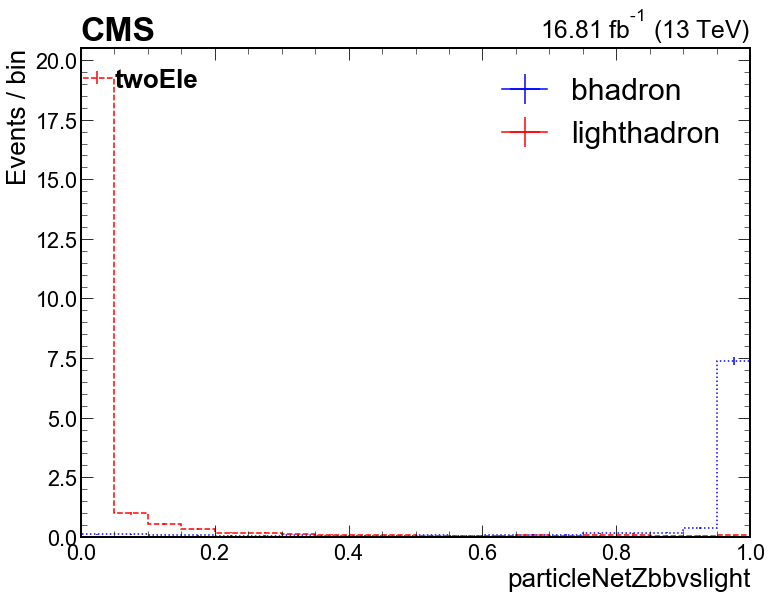

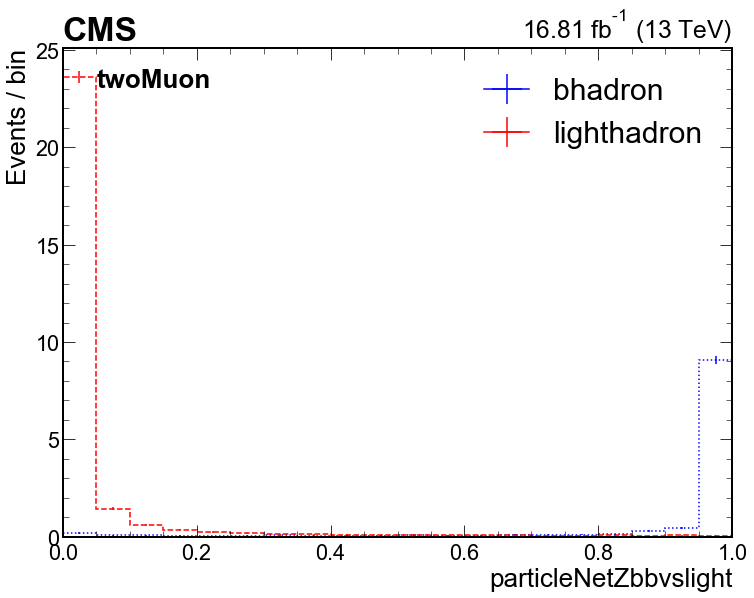

In [18]:
#draw var
for cat in cats:
    if cat =='isEE':
        text = 'twoEle'
    elif cat =='isMuMu':
        text = 'twoMuon'
    print(f"[INFO] it is {cat} plot")
    plot_unce = True
    #set_sns_color(color_order_bkg)
    f = plt.figure(figsize=(12,12))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
    ##================================ Upper histogram panel=========================================
    ax = f.add_subplot(gs[0])
    hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
    ax.set_xlim(xmin, xmax); ax.set_ylabel('Events / bin', ha='right', y=1.0)
    
    r"""
    ##BACKGRUND
    #hep.histplot(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    plot_hist(bkg_hists[cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
    bkg_hist = bkg_hists[cat][0]+bkg_hists[cat][1]+bkg_hists[cat][2]
    bkg_tot = bkg_hist.values()
    bkg_err = get_err(bkg_hist)
    #bkg_err = np.sqrt(bkg_hist.view(flow=False).variance)

    if plot_unce:
        #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='dimgrey', facecolor='none', linewidth=0) ## draw bkg unce. 
        ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
    ax.set_xlim(xmin, xmax); ax.set_xticklabels([]);
    ax.set_ylabel('Events / bin', ha='right', y=1.0);
    """
    
    ##SIGNAL
    colors = ['blue', 'red']
    plot_hist(signal_hists[cat],label=[ var for var in ['bhadron','lighthadron']],linestyle=[style for style in [':','--']], color=[color for color in colors])
    ax.set_xlim(xmin, xmax); ax.set_xlabel(bininfo[var][3], ha='right', x=1.0)
    
    r"""
    ##DATA
    data_err = get_err(Data_hist[cat])
    data = Data_hist[cat].values()
    #hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    plot_hist(Data_hist[cat],label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
    
    if islogY:
        ax.set(yscale = "log")
        ax.set_ylim(1e-1, 3*ax.get_ylim()[1])
    else:
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.set_ylim(0, 1.5*max(data))
    """
    ax.text(0.05, 0.92, f'{text}', transform=ax.transAxes, fontweight='bold')
    hep.plot.yscale_legend
    ax.legend(fontsize=30)